In [1]:
from climateclassy import DataLoader, ClimateClassifier
import os
from datetime import datetime as dt
import logging
from climateclassy import DataLoader, ClimateClassifier


# we create a directory to check info from each execution
app_name = '../tfm/first_dataset_tests' # with monthly frequency
date = dt.today().strftime('%y%m%d')
logs_path = 'logs'

filename = dt.today().strftime('%y%m%d')  + '.log'

if not os.path.isdir(os.path.join(app_name, date, logs_path)):
    os.mkdir(os.path.join(app_name, date, logs_path))

logging.basicConfig(
    level=logging.INFO,
    format='%(levelname)s - %(asctime)s - %(message)s',

    handlers=[
        logging.FileHandler(os.path.join(app_name, date, logs_path, filename)),
        logging.StreamHandler()
    ]
)

if not os.path.isdir(os.path.join(app_name, date, 'results')):
    os.mkdir(os.path.join(app_name, date, 'results'))

results_path = os.path.join(app_name, date, 'results')


df_path = '../tfm2/test_data/assaig1'
variables = ['Lag_RN_ERA_Ix5day_2', 'Lag_SM_GLEAM_ResPlusTrend_Sx5day_2','maxTXx_cum_T_ERA_2', 'monthly_Rx1day_P_CPCU']
path_to_model = '../tfm/first_dataset_tests/230412/results/best_model_step1.h5'

data = DataLoader(df_path, variables, data_format = 'csv')

classy = ClimateClassifier(data, variables, results_path, n_clusters = 5, sample_size = 40, path_to_model = '../tfm/first_dataset_tests/230412/results/best_model_step1.h5', epochs_step1=500, epochs_final= 200)

2023-04-12 14:03:51.682050: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-12 14:03:51.730069: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-12 14:03:51.730879: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-12 14:03:52.515729: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
INFO - 2023-04-12 14:03:53,907 - DataLoader object initialised
INFO - 2023-04-12 14:03:53,908 - Loading data with csv format
INFO - 2023-04-12 14:03:54,155 - Saving pixels index
INFO - 2023-04-12 14:03:54,156 - 184 pixels saved


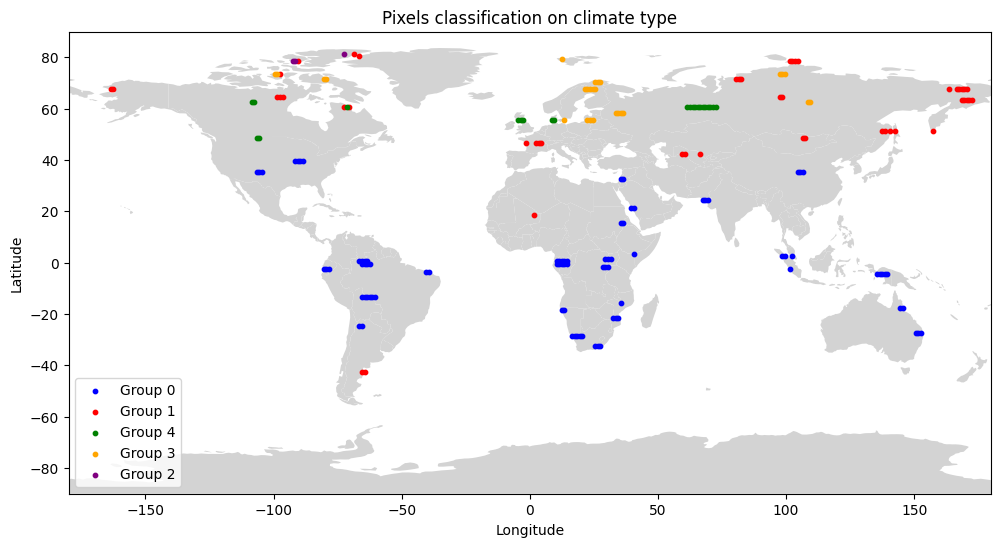

In [2]:
classy.plot_results()

In [1]:
# libraries used
import pandas as pd
import numpy as np
import os
import datetime
import netCDF4
import logging

import geopandas as gpd
import matplotlib.pyplot as plt

from tensorflow.keras import layers, Model
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

from tslearn.clustering import TimeSeriesKMeans
from tslearn.barycenters import dtw_barycenter_averaging as dtw_avg

2023-04-12 10:46:13.329888: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-12 10:46:13.377327: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-12 10:46:13.378412: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-12 10:46:14.161735: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
model = tf.keras.models.load_model('../tfm/second_dataset_tests/230411/results/best_model.h5')

2023-04-12 10:50:05.120449: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 46, 4)]           0         
                                                                 
 time_distributed (TimeDistr  (None, 46, 50)           250       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 46, 10)           510       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 46, 1)            11        
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 46, 10)           20        
 tributed)                                                   

In [11]:
encoder_layers = model.layers[:4] 

In [12]:
encoder_layers

In [15]:
inp = layers.Input(shape=(46, 4))

encoder = layers.TimeDistributed(layers.Dense(50, activation='tanh'))(inp)
encoder1 = layers.TimeDistributed(layers.Dense(10, activation='tanh'))(encoder)
latent = layers.TimeDistributed(layers.Dense(1, activation='tanh'))(encoder1)

encoder_model = Model(inp, latent)

In [17]:
encoder_model.get_layer('time_distributed_3').set_weights(model.get_layer('time_distributed').get_weights())

In [20]:
encoder_model.get_layer('time_distributed_4').set_weights(model.get_layer('time_distributed_1').get_weights())

In [21]:
encoder_model.get_layer('time_distributed_5').set_weights(model.get_layer('time_distributed_2').get_weights())

In [22]:
df = pd.read_csv('../tfm/first_dataset_tests/230412/results/clustering_results.csv')

In [23]:
df

,Unnamed: 0,group,coord_x,coord_y
0,0,0,31.5,1.5
1,1,0,30.5,1.5
2,2,0,-60.5,-13.5
3,3,1,106.5,48.5
4,4,0,99.5,2.5
...,...,...,...,...
179,179,1,168.5,67.5
180,180,0,139.5,-4.5
181,181,0,152.5,-27.5
182,182,1,81.5,71.5
